In [1]:
import numpy as np
import pandas as pd
import pickle
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,gaussian_kde,spearmanr

In [2]:
cols = ['Distance_from_hole','Cat','Par_Value','Year','Course_#','Round','Player_#','Strokes_Gained','Permanent_Tournament_#']

In [3]:
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])

In [4]:
rdata = pd.read_csv('./../data/round.csv')

In [5]:
rdata.head(2)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position
0,2003,16,656,1320,"Estes, Bob",1,66,T6,Mercedes Championships,271,4,0.208333
1,2003,16,656,1361,"Forsman, Dan",1,69,T21,Mercedes Championships,279,4,0.611111


In [6]:
with open('./../PickleFiles/tourn_order.pkl','r') as pickleFile:
    tourn_order = pickle.load(pickleFile)

with open('./../PickleFiles/course_order.pkl','r') as pickleFile:
    course_order = pickle.load(pickleFile)

In [7]:
tourn_order[0:4],course_order[0:4]

([(2003, 16), (2003, 6), (2003, 3), (2003, 2)], [656, 6, 510, 649])

In [8]:
def make_specific_cats(distance,cat,par):
    if cat=='Tee Box':
        if par==3:
            return 'Tee-3'
        else:
            return 'Tee-45'
    elif cat=='Bunker' or cat=='Other':
        return cat
    elif cat=='Green' or cat=='Fringe':
        if distance<5:
            return 'Green-0'
        elif distance<10:
            return 'Green-5'
        elif distance<20:
            return 'Green-10'
        else:
            return 'Green-20'
    elif cat=='Fairway':
        if distance<300:
            return 'Fairway-0'
        elif distance<540:
            return 'Fairway-300'
        else:
            return 'Fairway-540'
    elif cat=='Primary Rough' or cat=='Intermediate Rough':
        if distance<90:
            return 'Rough-0'
        elif distance<375:
            return 'Rough-90'
        else:
            return 'Rough-375'

In [9]:
data.insert(len(data.columns),'Specific_Cat',
            [make_specific_cats(tup[0],tup[1],tup[2]) 
             for tup in data[['Distance_from_hole','Cat','Par_Value']].values.tolist()])

In [10]:
data.Specific_Cat.value_counts()

Green-0        2818013
Tee-45         2781546
Green-20       1358330
Fairway-300    1145044
Green-10       1035734
Green-5         874724
Tee-3           823746
Rough-375       695727
Fairway-540     641033
Fairway-0       602925
Bunker          503585
Rough-0         480052
Rough-90        262059
Other            68023
Name: Specific_Cat, dtype: int64

First a baseline of SG to field using simple average SG on different categories of shots.

In [11]:
course_profiles = defaultdict(lambda: defaultdict(list))
cats = pd.unique(data.Specific_Cat)
for year,tourn in tourn_order:
    for (course,round),day in data[(data.Year==year) & (data['Permanent_Tournament_#']==tourn)].groupby(['Course_#','Round']):
        rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
        if len(rday)==0 or len(day)==0:
            continue
        players = pd.unique(day['Player_#'])
        cat_aves = {}
        for cat in cats:
            df = day[day.Specific_Cat==cat]
            if len(df)==0:
                cat_aves[cat] = [0.0]*len(players)
            player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
            cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 for player in players])
        ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
        score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
        score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan for player in players])
        for cat in cats:
            cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
            course_profiles[course][cat].append(spearmanr(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0])

In [12]:
for cat in pd.unique(data.Specific_Cat):
    print '**** %s ****' % cat
    for course in course_profiles:
        print course,len(course_profiles[course][cat]),np.mean(course_profiles[course][cat])

**** Tee-45 ****
512 11 -0.229713373866
513 56 -0.253434228838
770 28 -0.288027003583
643 4 -0.331376893148
4 55 -0.267182332712
5 53 -0.21314729125
6 56 -0.256501159378
775 16 -0.273768631144
8 56 -0.275541748258
649 46 -0.151367040063
11 56 -0.230803528009
12 56 -0.199579217157
13 20 -0.261098470941
526 32 -0.290465693055
527 8 -0.24220367236
656 55 -0.182833467305
19 53 -0.226959740542
660 36 -0.283654924115
21 56 -0.243441830245
534 4 -0.332780293249
23 56 -0.238727602035
24 31 -0.286653473927
665 56 -0.222849245983
538 53 -0.27570877426
27 20 -0.26467678237
669 56 -0.278510899261
773 8 -0.335453911602
32 24 -0.274248083823
35 28 -0.302482818217
36 56 -0.38151881558
37 12 -0.39880355639
689 8 -0.311488093891
552 8 -0.306671671839
772 4 -0.283144402341
45 40 -0.271721596546
687 4 -0.311733865271
688 52 -0.266469216833
776 24 -0.207196332516
819 8 -0.27814990893
692 4 -0.183075079279
694 12 -0.329878794616
9 56 -0.264701644951
696 16 -0.246910364546
185 3 -0.0717029137605
698 56 -0.2

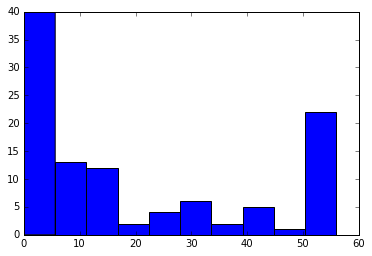

In [13]:
course_round_count = {course:0 for course in course_order}
for (year,tourn,course,round),_ in data.groupby(['Year','Permanent_Tournament_#','Course_#','Round']):
    course_round_count[course] += 1

plt.hist([course_round_count[key] for key in course_round_count.keys()]);

In [14]:
for key in sorted(course_round_count,key=course_round_count.get):
    print key,course_round_count[key]

2 0
530 0
613 0
102 0
104 0
145 0
670 0
681 0
690 0
202 0
712 0
205 0
733 0
741 0
742 0
231 0
763 0
769 0
780 0
302 0
822 0
233 0
185 3
534 4
616 4
642 4
643 4
671 4
687 4
692 4
695 4
704 4
706 4
715 4
726 4
736 4
740 4
751 4
772 4
505 4
717 7
781 7
527 8
552 8
56 8
689 8
716 8
746 8
762 8
773 8
789 8
819 8
512 11
37 12
694 12
699 12
710 12
713 12
745 12
511 12
723 15
101 16
696 16
730 16
775 16
13 20
27 20
638 23
32 24
771 24
776 24
35 28
612 28
625 28
770 28
24 31
526 32
660 36
752 36
45 40
609 40
734 40
714 43
729 44
649 46
688 52
5 53
19 53
538 53
500 54
4 55
656 55
513 56
6 56
8 56
9 56
11 56
12 56
21 56
23 56
36 56
665 56
669 56
698 56
700 56
503 56
510 56


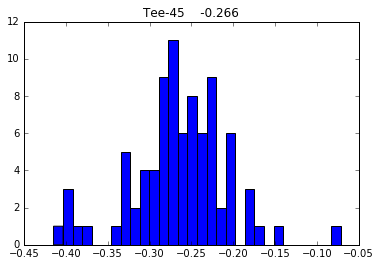

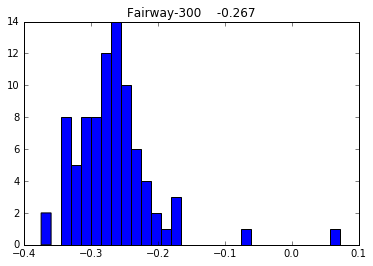

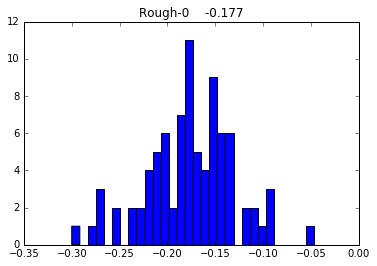

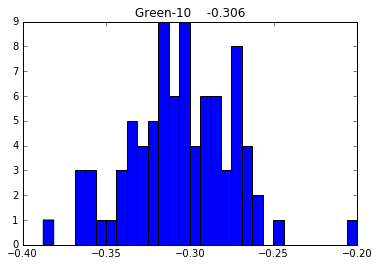

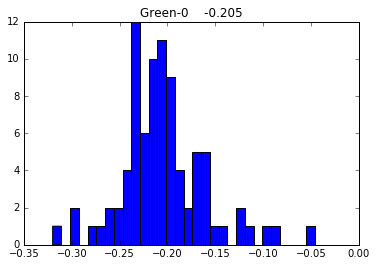

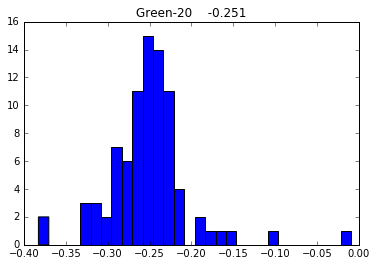

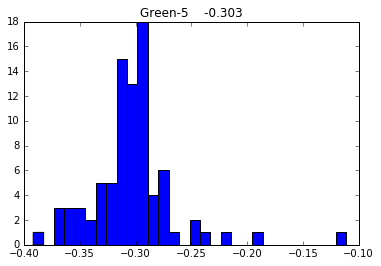

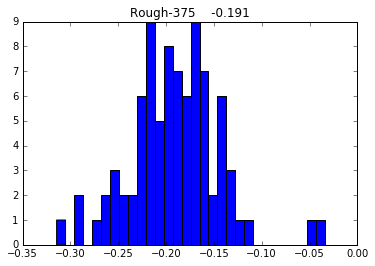

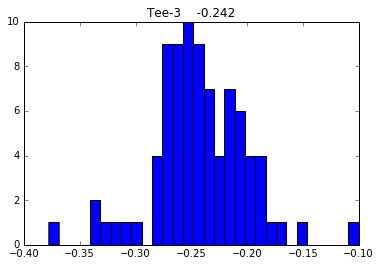

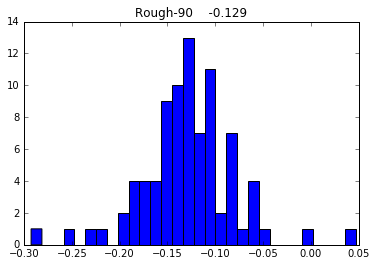

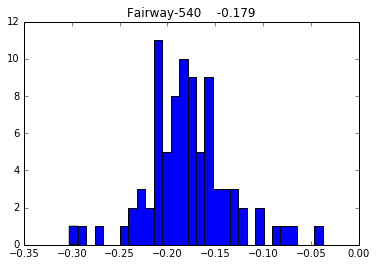

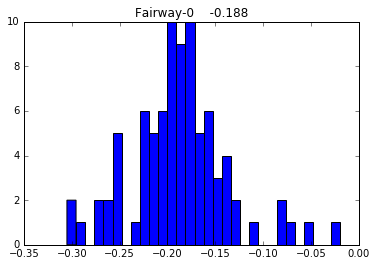

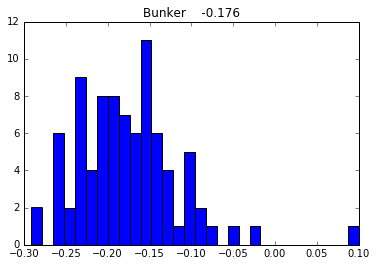

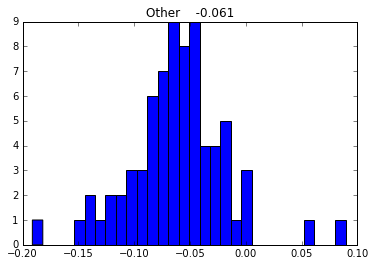

In [15]:
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    plt.hist(x,bins=30)
    plt.title(cat+'    %.3f' % np.mean(x))
    plt.show()

Set Priors

In [16]:
priors = defaultdict(None)
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    priors[cat] = (np.mean(x),np.std(x))

In [17]:
priors

defaultdict(None,
            {'Bunker': (-0.1761811359465168, 0.060299350950924049),
             'Fairway-0': (-0.18766057137181039, 0.050230364635365531),
             'Fairway-300': (-0.26687255348702904, 0.060317950772401277),
             'Fairway-540': (-0.17861132007527983, 0.043704898296544489),
             'Green-0': (-0.20530898140545706, 0.044467281966769114),
             'Green-10': (-0.30616697169682594, 0.031170210958602215),
             'Green-20': (-0.25137418782732052, 0.048913366528076971),
             'Green-5': (-0.30276284072562842, 0.037869550142824726),
             'Other': (-0.061243153455796284, 0.043157238758745671),
             'Rough-0': (-0.17672014143930426, 0.045998330050454235),
             'Rough-375': (-0.19101741234114314, 0.046219990310250439),
             'Rough-90': (-0.12921761539986062, 0.048029758847939065),
             'Tee-3': (-0.24232304854449632, 0.042026460661457689),
             'Tee-45': (-0.26570822918956977, 0.05677749939649

In [18]:
for cat in pd.unique(data.Specific_Cat):
    mean,std = priors[cat][0],priors[cat][1]
    priors[cat] = [np.linspace(mean-3*std,mean+3*std,100),
                   norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std)/
                    norm.pdf(np.linspace(mean-3*std,mean+3*std,100),mean,std).sum()]

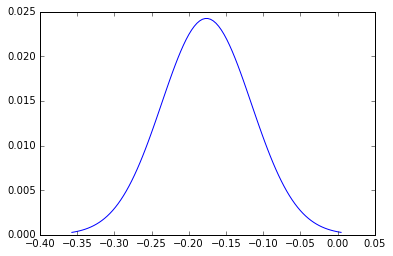

In [19]:
plt.plot(priors['Bunker'][0],priors['Bunker'][1]);

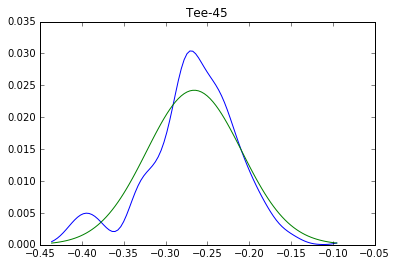

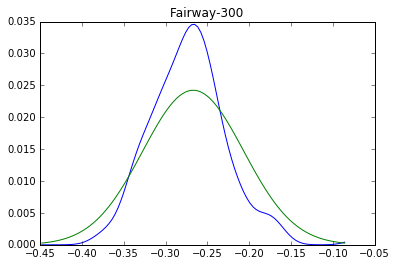

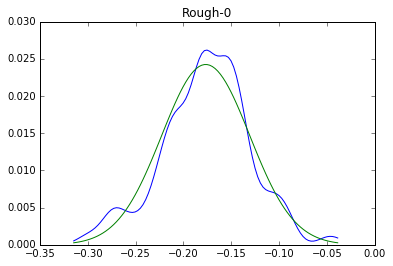

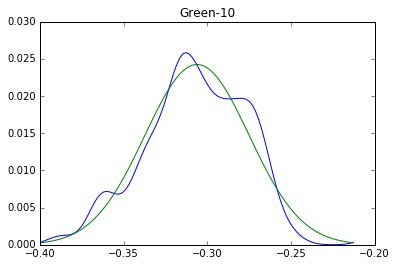

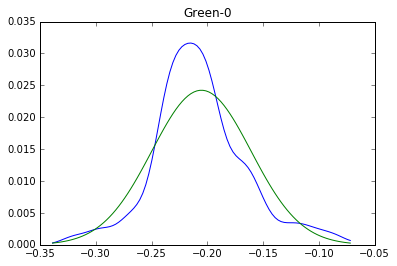

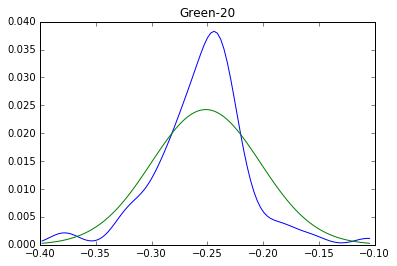

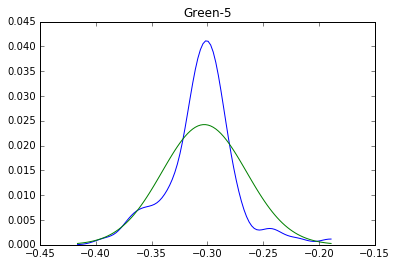

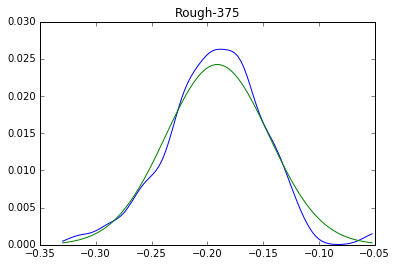

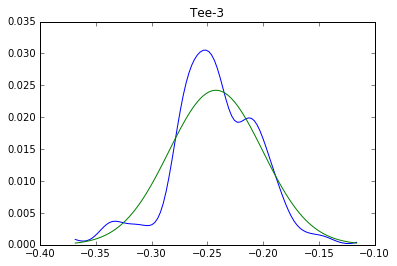

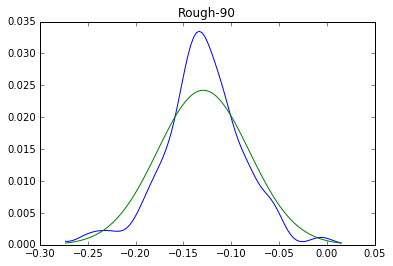

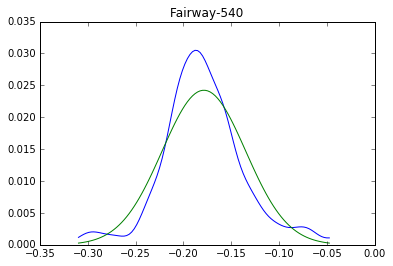

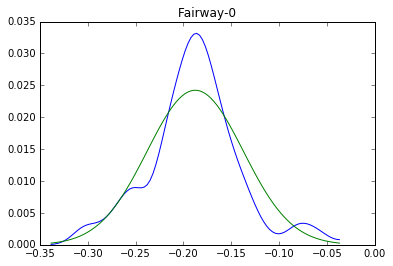

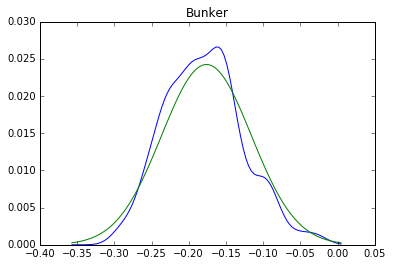

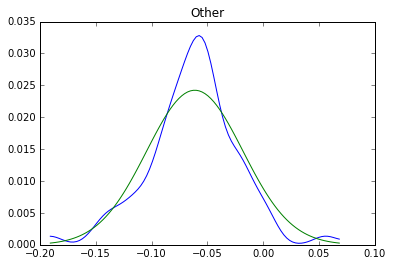

In [20]:
num_courses = len(pd.unique(data['Course_#']))
for cat in pd.unique(data.Specific_Cat):
    x = []
    for course in course_profiles:
        if np.isnan(np.mean(course_profiles[course][cat])):
            continue
        x.append(np.mean(course_profiles[course][cat]))
    density = gaussian_kde(x)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(priors[cat][0],density(priors[cat][0])/density(priors[cat][0]).sum())
    plt.plot(priors[cat][0],priors[cat][1])
    plt.title(cat)
    plt.show()

Update based on data for each course, estimate posteriors

In [21]:
def update(x,p_x,r,n):
    se = 1.06/(n-3.0)**.5
    p_x *= norm.pdf(np.arctanh(x)-np.arctanh(r),0,se)
    p_x /= p_x.sum()
    return p_x

In [22]:
course_posteriors = {course:copy.deepcopy(priors) for course in course_order}
to_return = {cat:np.zeros((len(tourn_order),len(course_order))) for cat in cats}
for u,(year,tourn) in enumerate(tourn_order):
    for cat in cats:
        to_return[cat][u,:] = np.array([np.dot(course_posteriors[course][cat][0],course_posteriors[course][cat][1])
                                        for course in course_order])
    for (course,round),day in data[(data.Year==year) & (data['Permanent_Tournament_#']==tourn)].groupby(['Course_#','Round']):
        rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
        if len(rday)==0 or len(day)==0:
            continue
        players = pd.unique(day['Player_#'])
        cat_aves = {}
        for cat in cats:
            df = day[day.Specific_Cat==cat]
            if len(df)==0:
                cat_aves[cat] = [0.0]*len(players)
            player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
            cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 for player in players])
        ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
        score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
        score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan for player in players])
        for cat in cats:
            cat_aves[cat] = cat_aves[cat][~np.isnan(score_vec)]
            if np.isnan(spearmanr(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0]):
                continue
            course_posteriors[course][cat][1] = update(course_posteriors[course][cat][0],
                                                       course_posteriors[course][cat][1],
                                                       spearmanr(score_vec[~np.isnan(score_vec)],cat_aves[cat])[0],
                                                       cat_aves[cat].shape[0])

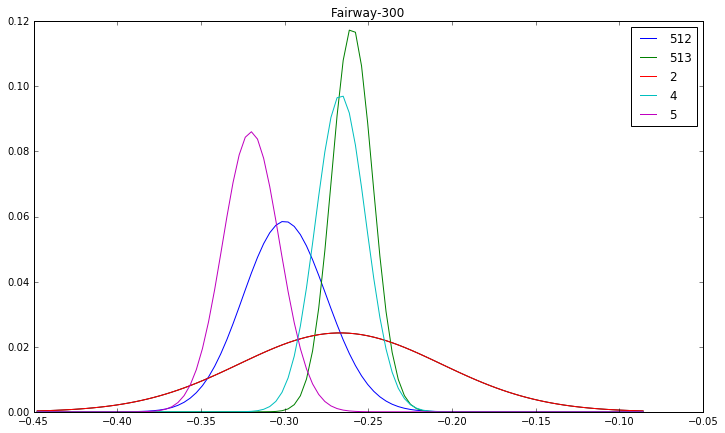

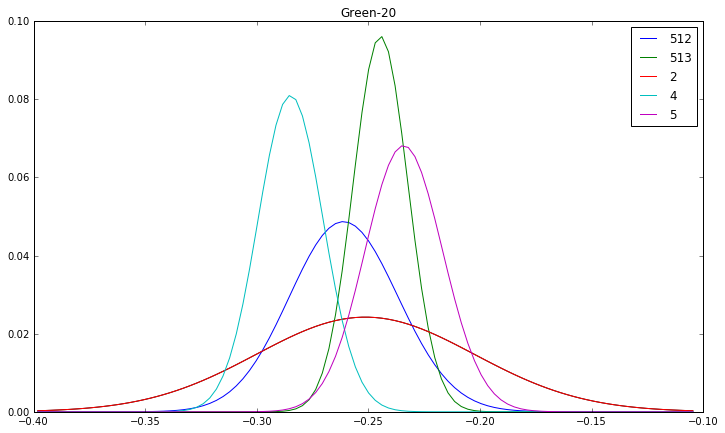

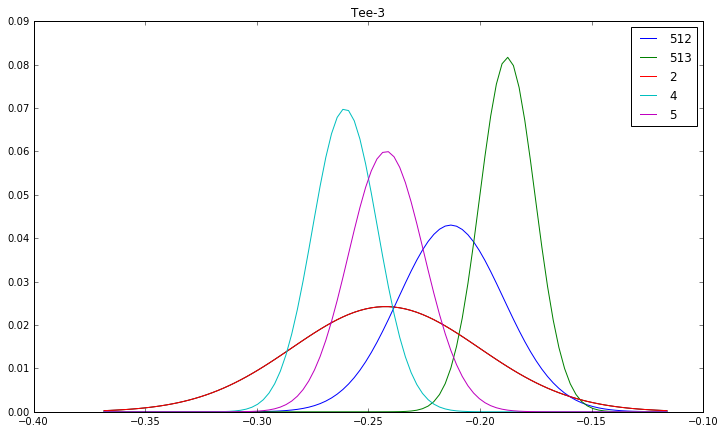

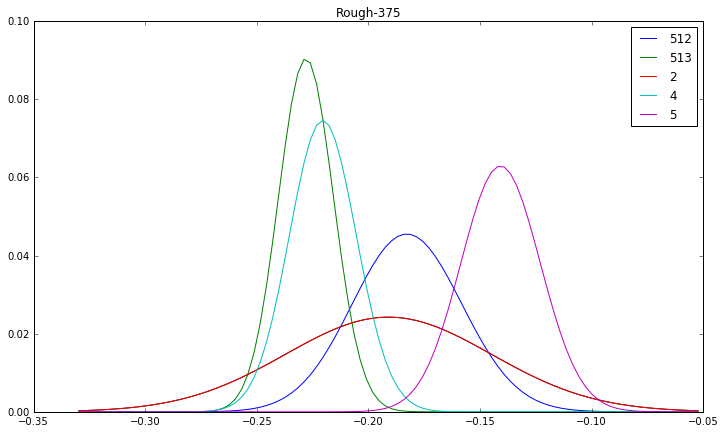

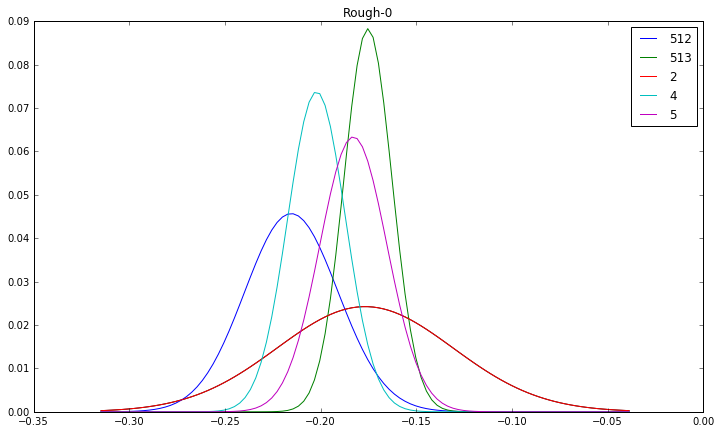

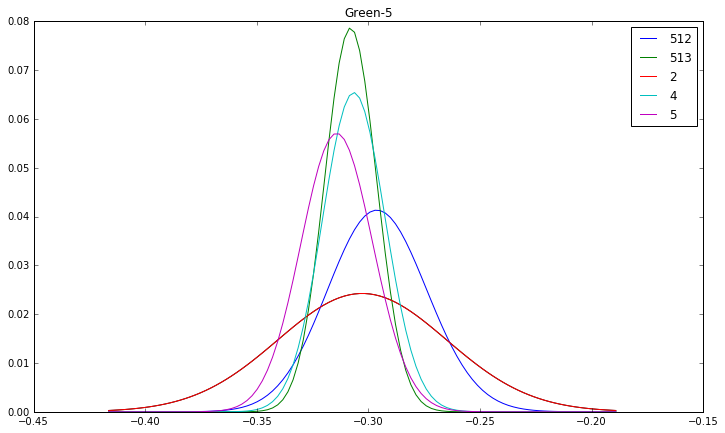

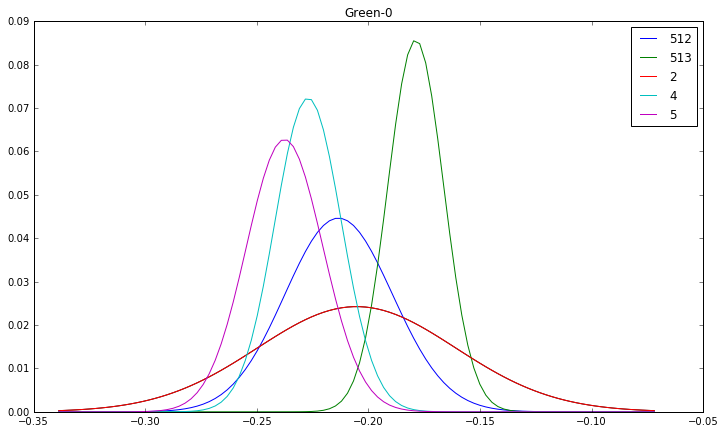

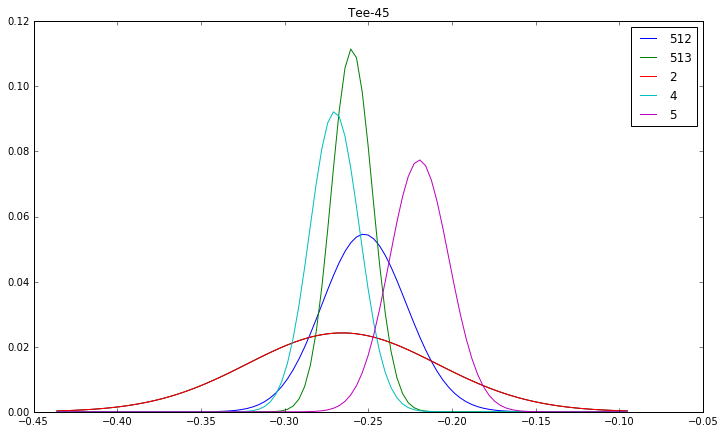

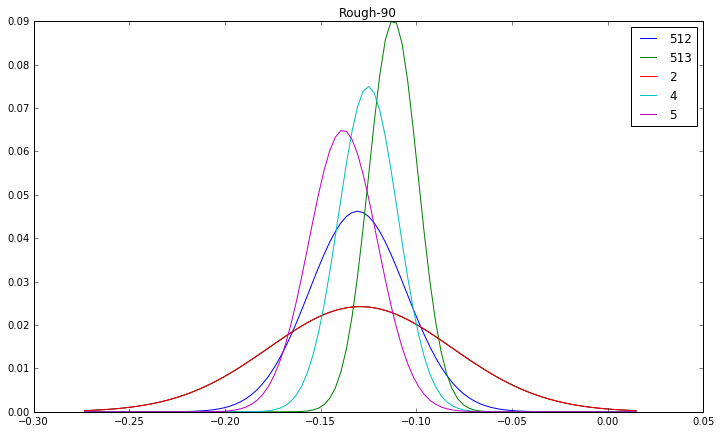

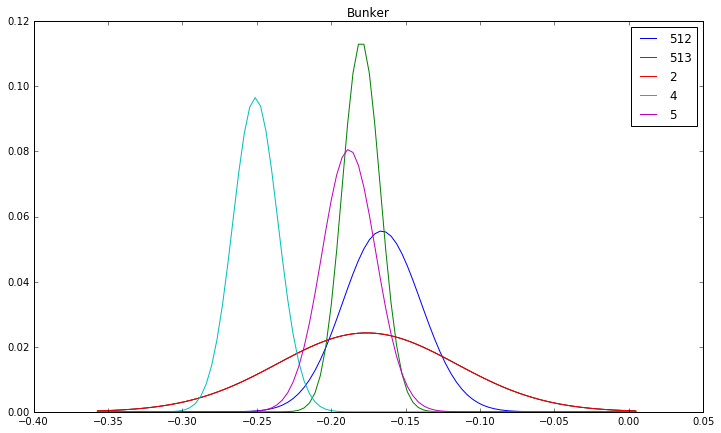

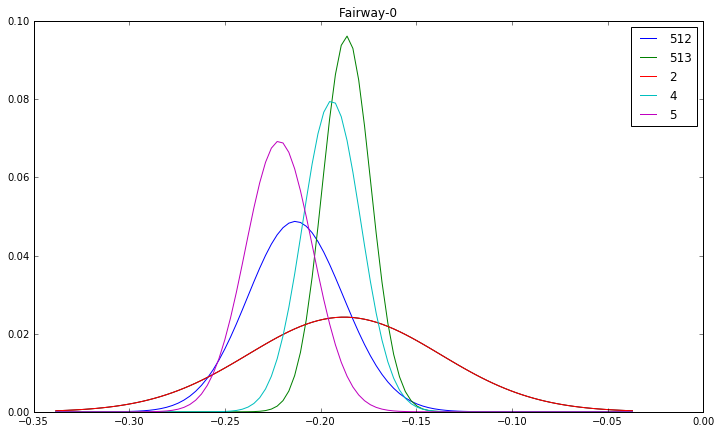

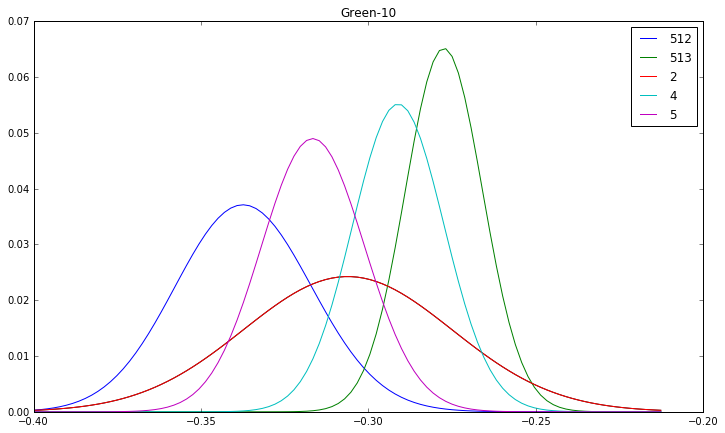

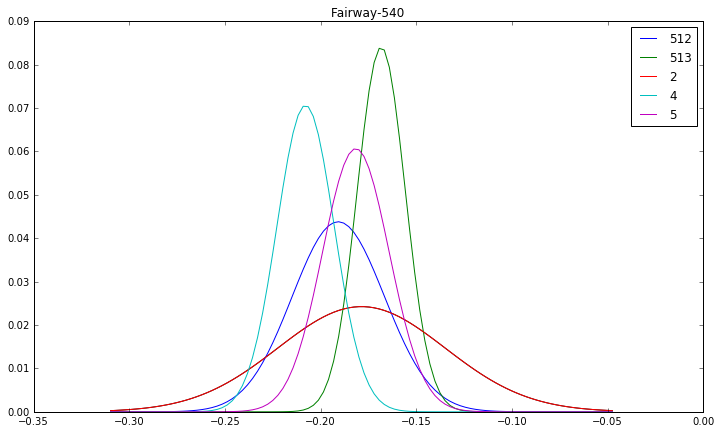

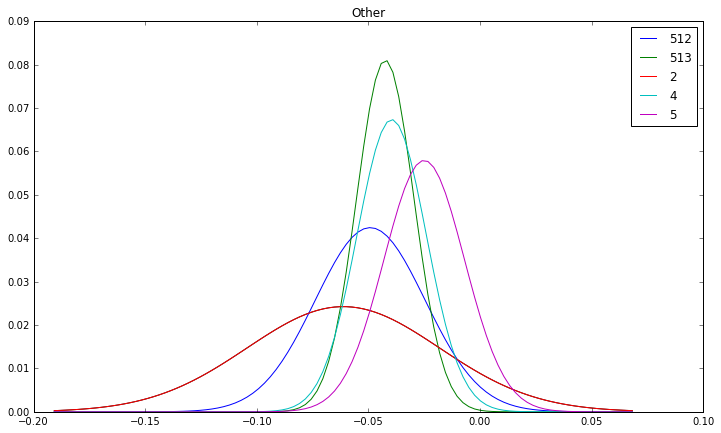

In [23]:
for cat in course_profiles[course_profiles.keys()[0]]:
    plt.figure(figsize=(12,7))
    plt.plot(priors[cat][0],priors[cat][1],c='black')
    for course in course_posteriors.keys()[:5]:
        plt.plot(course_posteriors[course][cat][0],course_posteriors[course][cat][1],label=str(course));
    plt.title(cat)
    plt.legend()
    plt.show();

Overall importances

In [24]:
overall_importances = defaultdict(list)
big_score_vec = []
for year,tourn in tourn_order:
    for (course,round),day in data[(data.Year==year) & (data['Permanent_Tournament_#']==tourn)].groupby(['Course_#','Round']):
        rday = rdata[(rdata.Tournament_Year==year) & (rdata['Course_#']==course) & (rdata.Round_Number==round)]
        if len(rday)==0 or len(day)==0:
            continue
        players = pd.unique(day['Player_#'])
        cat_aves = {}
        for cat in cats:
            df = day[day.Specific_Cat==cat]
            if len(df)==0:
                cat_aves[cat] = [0.0]*len(players)
            player_map = df.groupby('Player_#').Strokes_Gained.mean().to_dict()
            cat_aves[cat] = np.array([player_map[player] if player in player_map else 0.0 for player in players])
        ave_score = rday.groupby('Player_Number').Round_Score.mean().mean()
        score_map = rday.groupby('Player_Number').Round_Score.mean().to_dict()
        score_vec = np.array([score_map[player]-ave_score if player in score_map else np.nan for player in players])
        big_score_vec.extend(score_vec[~np.isnan(score_vec)].tolist())
        for cat in cat_aves:
            overall_importances[cat].extend(cat_aves[cat][~np.isnan(score_vec)].tolist())

In [25]:
corrs = {cat:spearmanr(big_score_vec,overall_importances[cat])[0] for cat in cats}
for cat in sorted(corrs,key=corrs.get):
    print cat, corrs[cat]

Green-5 -0.304635003447
Green-10 -0.298560712671
Fairway-300 -0.271912193602
Green-20 -0.248389350017
Tee-3 -0.241918310959
Tee-45 -0.238585058898
Green-0 -0.214935007235
Fairway-0 -0.190956904481
Rough-375 -0.190324914205
Bunker -0.185171215986
Fairway-540 -0.17414633026
Rough-0 -0.173600250534
Rough-90 -0.126970122826
Other -0.0648065803405


In [26]:
corrs = {cat:np.corrcoef(big_score_vec,overall_importances[cat])[0,1] for cat in cats}
for cat in sorted(corrs,key=corrs.get):
    print cat, corrs[cat]

Green-10 -0.293360613291
Green-5 -0.293083180796
Fairway-300 -0.270086388346
Tee-45 -0.252125295916
Tee-3 -0.251917219185
Green-20 -0.25178153023
Green-0 -0.230497445365
Rough-375 -0.186229873972
Fairway-0 -0.185500960078
Bunker -0.184993891541
Rough-0 -0.171943488962
Fairway-540 -0.171656907377
Rough-90 -0.133920942709
Other -0.0722673616294
